# Non-incremental online learning of parallelizable Reservoir

In [1]:
# @title Loading data

from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/Colab Notebooks/sp500.csv'

import pandas as pd
import numpy as np

data = pd.read_csv(file_path)
data = np.array(data)

#data reshaping

data = data[:,1:]
data = np.array(data, dtype=float)

#standardization

mean_value = np.mean(data, axis=0)
std_dev = np.std(data, axis=0)
data = (data - mean_value) / std_dev

data = data.T

Mounted at /content/drive


In [2]:
# @title Loading optuna

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import scipy.signal
import networkx as nx
import csv

!pip install optuna
import optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 18.9 MB/s eta 0:00:00


Data shape: (503, 387)


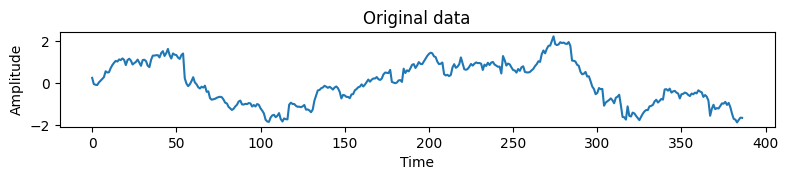

In [3]:
# @title visualization of data

import matplotlib.pyplot as plt
#import numpy as np
import scipy.stats
import scipy.signal
import datetime
import networkx as nx
import csv


print('Data shape:',data.shape)

plt.figure(figsize=(8, 3))

plt.subplot(2, 1, 1)
plt.plot(data[4,:])
plt.title('Original data')
plt.xlabel('Time')
plt.ylabel('Amplitude')


plt.tight_layout()
plt.show()


In [4]:
# @title Definition of Reservoir computing (without ``Class" setting!!)

####################
#input weight matrix
####################

def input_matrix(N_x,seed_value,input_scale,dim):

# Separate integer and decimal portions
    seed_int_low = int(np.floor(seed_value))
    seed_int_high = int(np.ceil(seed_value))
    fraction = seed_value - seed_int_low

# Random number generation for integer part
    np.random.seed(seed_int_low)
    random_matrix_low = np.random.uniform(-input_scale, input_scale, (N_x, dim))
    np.random.seed(seed_int_high)
    random_matrix_high = np.random.uniform(-input_scale, input_scale, (N_x, dim))

# Linear interpolation allows random seed values to correspond continuously to the matrix
    interpolated_matrix = (1 - fraction) * random_matrix_low + fraction * random_matrix_high

    return interpolated_matrix

##############################
# Recurrent weight matrix
##############################

def generate_random_binary_matrix(N_x, dim, density, seed_value_binary):

    num_ones = int(N_x*dim * density)

    matrix = np.zeros(N_x*dim, dtype=int)

    np.random.seed(seed_value_binary)

    ones_indices = np.random.choice(N_x*dim, num_ones, replace=False)
    matrix[ones_indices] = 1

    return matrix.reshape((N_x, dim))


def recurrent_matrix(N_x, density, rho,seed_value):

# Separate random seed value into integer and decimal portions
        seed_int_low = int(np.floor(seed_value))
        seed_int_high = int(np.ceil(seed_value))
        fraction = seed_value - seed_int_low

        random_binary_matrix_low   = generate_random_binary_matrix(N_x, N_x, density, seed_int_low)
        random_binary_matrix_high  = generate_random_binary_matrix(N_x, N_x, density, seed_int_high)
        interpolated_binary_matrix = \
         (1 - fraction) * random_binary_matrix_low + fraction * random_binary_matrix_high


# Separate integer and decimal portions
        seed_int_low = int(np.floor(seed_value))
        seed_int_high = int(np.ceil(seed_value))
        fraction = seed_value - seed_int_low

# Generate nonzero elements as random numbers following a uniform distribution
        rec_scale = 1.0

# Random number generation based on integer part
        np.random.seed(seed_int_low)
        random_matrix_low = np.random.uniform(-rec_scale, rec_scale, (N_x, N_x))
        np.random.seed(seed_int_high)
        random_matrix_high = np.random.uniform(-rec_scale, rec_scale, (N_x, N_x))

# Linear interpolation allows random seed values and matrices to correspond continuously
        interpolated_matrix = (1 - fraction) * random_matrix_low + fraction * random_matrix_high

        W = interpolated_binary_matrix * interpolated_matrix

        # Calculation of spectral radius
        eigv_list = np.linalg.eigh(W)[0]
        sp_radius = np.max(np.abs(eigv_list))

        # Scaling to a specified spectral radius rho
        W *= rho / sp_radius
        return W

#############################
# reservoir state vector
#############################

def Reservoir(x_in,x,W,alpha,bias_scale):

        Wbias = np.ones(len(x_in))
        Wbias = Wbias * bias_scale

        x = (1.0 - alpha) * x \
                 + alpha * np.tanh(np.dot(W, x)+Wbias \
                 + x_in)
        return x

############################
#Ridge Regression and  Output Weight Matrix
############################

def Ridge(d, x, X_XT,D_XT):

        x = np.reshape(x, (-1, 1))
        d = np.reshape(d, (-1, 1))
        X_XT += np.dot(x, np.transpose(x))
        D_XT += np.dot(d, np.transpose(x))
        return X_XT, D_XT

def get_Wout_opt(X_XT,D_XT,N_x,beta):

        Wout_opt = np.linalg.solve((X_XT + beta * np.identity(N_x)).T, D_XT.T)
        Wout_opt=Wout_opt.T

        return Wout_opt

###################
#Definition of batch learning (convexity)
###################

def train(train_U,train_D, x, T_train,Win,W,N_x,dim,alpha,discard_len,bias_scale):


    X_XT          = np.zeros((N_x, N_x))
    D_XT          = np.zeros((dim, N_x))
    x_special_vec = np.zeros((train_U.shape[0],N_x))

    for m in range(train_U.shape[0]):

        x = np.zeros(N_x)

        for n in range(T_train):

            # reservoir state vector
            x = Reservoir(np.dot(Win,train_U[m,n,:]),x,W,alpha,bias_scale)

            # teacher data
            d = train_D[m,n,:]


            if n > discard_len:  # discard the first part of the data
                 X_XT, D_XT = Ridge(d, x, X_XT, D_XT)

        x_special_vec[m,:] = x

    return X_XT, D_XT,x_special_vec


########################
#induction formula for creating estimated data
########################

def run(test_U,x,Win,W,Wout,alpha,T_test,bias_scale):


    Y_pred = []
    y = test_U[0,:]


    for n in range(T_test):

        x = Reservoir(np.dot(Win,y),x,W,alpha,bias_scale)
        y_pred = np.dot(Wout, x)
        Y_pred.append(y_pred)
        y = y_pred

    return np.array(Y_pred)

In [5]:
# @title Def of model selection（using Optuna）

%%time

from optuna.trial import FrozenTrial
from optuna.trial import TrialState
from datetime import datetime
import os

####################################
#indicator function

def sign_indicator(x):
    if x > 0:
        return 1
    elif x < 0:
        return -1
    else:
        return 0

def sign_onezero(x):
    if x > 0:
        return 1
    elif x < 0:
        return 0
    else:
        return 0
####################################

def heaviside_ratio(A, B):
    product = A * B
    # heaviside(x, 0): x > 0 → 1, x == 0 → 0, x < 0 → 0
    heaviside = np.heaviside(product, 0)
    ratio = np.mean(heaviside)
    return ratio

####################################


# def objection function
def objective(trial):
    lag = trial.suggest_int("lag", max_lag, max_lag)
    dim = trial.suggest_int("dim", max_dim, max_dim)
    N_x = trial.suggest_int("N_x", Node, Node)                #Initially fixed here
    beta = trial.suggest_float("beta", 0.0001, 0.0001)
    density = trial.suggest_float("density", 0.01, 1)
    input_scale = trial.suggest_float("input_scale", 0, 1.5)
    rho = trial.suggest_float("rho", 0, 1.5)
    alpha = trial.suggest_float("alpha", 0, 1)
    seed_value = trial.suggest_float("seed_value", 0, 100)
    bias_scale = trial.suggest_float("bias_scale", -1.5, 1.5)

    #starting test time

    T_0 = T_train + lag * dim

    #determine input and recurrent weight matrices

    Win= input_matrix(N_x,seed_value,input_scale,dim)
    W = recurrent_matrix(N_x, density, rho,seed_value)

    #initialization

    data_delay_train = np.zeros((impl_set.shape[0],T_train+1,dim), dtype=float)
    test_Y           = np.zeros((impl_set.shape[0],T_test,test_num))
    test_D           = np.zeros((impl_set.shape[0],T_test,test_num))

##########################################
#Convert training data to a delay coordinate system


    for i in range(dim):

        data_delay_train[:,:,i] = impl_set[:,T_0-T_train-i*lag:T_0-i*lag+1] # i*lag Step-delayed time series


# Initialization of training data

    train_U = np.zeros((impl_set.shape[0],T_train,dim), dtype=float)
    train_D = np.zeros((impl_set.shape[0],T_train,dim), dtype=float)

#Input/output of training data

    train_U = data_delay_train[:,:T_train,:]
    train_D = data_delay_train[:,1:T_train+1,:]

##The last time data of the training data output must overlap with the test data!

#Ridge
    X_XT          = np.zeros((N_x, N_x))
    D_XT          = np.zeros((dim, N_x))
    x_special_vec = np.zeros((train_U.shape[0],N_x))

    X_XT, D_XT,_ = train(train_U,train_D,np.zeros(N_x),T_train, \
                                  Win, W, N_x, dim, alpha,discard_len,bias_scale)

# Generate output weight matrix

    Wout= None
    Wout= get_Wout_opt(X_XT, D_XT,N_x,beta)

###############
    data_delay_test         = np.zeros((T_test+1,dim,test_num), dtype=float)
    tentative_test_Y        = np.zeros((T_test,dim,test_num))
    data_delay_train_resvec = np.zeros((impl_set.shape[0],T_train+1,dim,test_num), dtype=float)
    updown_pred             = np.zeros((impl_set.shape[0],test_num))
    updown_ans              = np.zeros((impl_set.shape[0],test_num))

###############
#Convert training data to a delay coordinate system (to generate reservoir state vec)

    for t in range(test_num):

        for i in range(dim):

            data_delay_train_resvec[:,:,i,t] = impl_set[:,T_0-T_train-i*lag+t:T_0-i*lag+1+t] # i*lag step delayed time series

    # Initialization of training data

        train_U = np.zeros((impl_set.shape[0],T_train,dim), dtype=float)
        train_D = np.zeros((impl_set.shape[0],T_train,dim), dtype=float)

    #Input/output of training data

        train_U[:,:,:] = data_delay_train_resvec[:,:T_train,:,t]
        train_D[:,:,:] = data_delay_train_resvec[:,1:T_train+1,:,t]

    ##The last time data of the training data output must overlap with the test data!

    #Ridge
        X_XT = np.zeros((N_x, N_x))
        D_XT = np.zeros((dim, N_x))
        x_special = np.zeros(N_x)

        _, _,x_special_vec = train(train_U,train_D,np.zeros(N_x),T_train, Win, W, N_x, dim, alpha,discard_len,bias_scale)




#######################
#Convert test data to a delay coordinate system

        for j in range (impl_set.shape[0]):

            for i in range(dim):

                data_delay_test[:,i,t] = impl_set[j,T_0-i*lag+t:
                                                T_0+T_test-i*lag+t+1] # i*lag step delayed time series


      #Generate estimated data


            tentative_test_Y[:,:,t] = run(data_delay_test[:T_test,:,t],x_special_vec[j,:], \
                                          Win,W,Wout,alpha,T_test,bias_scale)
            test_Y[j,:,t] = tentative_test_Y[:,0,t]
            test_D[j,:,t] = data_delay_test[1:T_test+1,0,t]


########################
#up or down

            updown_pred[j,t] = sign_indicator(test_Y[j,T_test-1,t]-data_delay_test[0,0,t])
            updown_ans[j,t] = sign_indicator(test_D[j,T_test-1,t]-data_delay_test[0,0,t])

    return  heaviside_ratio(updown_pred, updown_ans)

CPU times: user 33 µs, sys: 0 ns, total: 33 µs
Wall time: 38.9 µs


In [6]:
# @title Implement: Bayesian optimization of Reservoir

%%time


T_train      = 60   # Training period
T_test       = 5    # Forecast period
discard_len  = 15   # Number of steps not learned at the beginning (not important)
initial_time = 200  # Starting time


n_trials    = 60    # Number of times to test with optuna (generate accuracy for this number of times)


Node       = 30     # Reservoir Node
max_lag    = 1      # Maximum of lag for delay coordinate
max_dim    = 2      # Maximum of dimension for delay coordinate
test_num   = 1      # test numbers for each time series

MAX_TRIALS = 30     # Repeat the same thing while shifting each one step to produce robust result

###############################

print("data.shape:",data.shape)
print("data length from initial_time:",data[:,initial_time:].shape[1])
print("requirement of data length for one train-test:",T_train+max_lag*max_dim+2*T_test+test_num)

###############################



from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


mean_score     = []
score          = []

mean_accuracy  = []
mean_f1        = []
mean_precision = []
mean_recall    = []
accuracy  = []
f1        = []
precision = []
recall    = []


for trial in range(MAX_TRIALS):
    print(f"Trial {trial + 1}/{MAX_TRIALS}")

    impl_set = data[:,initial_time+trial:initial_time+T_train+max_lag*max_dim+2*T_test+test_num+trial]

    def stop_callback(study, trial):
        if study.best_value > 0.63:
            study.stop()


    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials, callbacks=[stop_callback])

    print("Best trial:")
    trial = study.best_trial
    print(f"  'params': {trial.params},")
    print(f"  'value': {trial.value},")

    lag  = trial.params["lag"]
    dim  = trial.params["dim"]
    N_x  = trial.params["N_x"]
    beta = trial.params["beta"]
    density = trial.params["density"]
    input_scale = trial.params["input_scale"]
    rho         = trial.params["rho"]
    alpha       = trial.params["alpha"]
    seed_value    = trial.params["seed_value"]
    bias_scale    = trial.params["bias_scale"]

###################################
##Test phase
###################################

    T_0 = T_train+lag*dim+1+test_num-1

    Win = input_matrix(N_x,seed_value,input_scale,dim)
    W   = recurrent_matrix(N_x, density, rho,seed_value)

    data_delay_train = np.zeros((impl_set.shape[0],T_train+1,dim), dtype=float)

####################################
#Convert test data to a delay coordinate system

    for i in range(dim):

        data_delay_train[:,:,i] = impl_set[:,T_0-T_train-i*lag:T_0-i*lag+1] # i*lag step delayed time series

    # Initialization of training data

    train_U = np.zeros((impl_set.shape[0],T_train,dim), dtype=float)
    train_D = np.zeros((impl_set.shape[0],T_train,dim), dtype=float)


    #Input/output of training data

    train_U = data_delay_train[:,:T_train,:]
    train_D = data_delay_train[:,1:T_train+1,:]

    ##The last time data of the training data output must overlap with the test data!

    #Ridge
    X_XT = np.zeros((N_x, N_x))
    D_XT = np.zeros((dim, N_x))

    X_XT, D_XT,_ = train(train_U,train_D,np.zeros(N_x),T_train, Win, W, N_x, dim, alpha,discard_len,bias_scale)

    #Generate output weight matrix
    Wout= None
    Wout= get_Wout_opt(X_XT, D_XT,N_x,beta)

    ######################################

    data_delay_train_resvec = np.zeros((T_train+1,dim,test_num), dtype=float)
    data_delay_test         = np.zeros((T_test+1,dim,test_num), dtype=float)
    test_Y                  = np.zeros((T_test,test_num))
    test_D                  = np.zeros((T_test,test_num))
    tentative_test_Y        = np.zeros((T_test,dim,test_num))

    updown_pred                  = np.zeros((impl_set.shape[0],test_num),dtype=float)
    updown_ans                   = np.zeros((impl_set.shape[0],test_num),dtype=float)
    updown_ans_select                   = np.zeros((impl_set.shape[0],test_num),dtype=float)
    updown_pred_select                 = np.zeros((impl_set.shape[0],test_num),dtype=float)
    heaviside_select                 = np.zeros((impl_set.shape[0],test_num),dtype=float)
    #######################################
    #Convert predictive data to a delay coordinate system


    for j in range (impl_set.shape[0]):

        for t in range(test_num):

            for i in range(dim):

                  data_delay_train_resvec[:,i,t] = impl_set[j,T_0-T_train-i*lag+t:T_0-i*lag+1+t] # i*lag step delayed time series

        # Initialization of training data

            train_U = np.zeros((1,T_train,dim), dtype=float)
            train_D = np.zeros((1,T_train,dim), dtype=float)

        #Input/output of training data

            train_U[0,:,:] = data_delay_train_resvec[:T_train,:,t]
            train_D[0,:,:] = data_delay_train_resvec[1:T_train+1,:,t]

        ##The last time data of the training data output must overlap with the test data!

        #Ridge
            X_XT = np.zeros((N_x, N_x))
            D_XT = np.zeros((dim, N_x))
            x_special = np.zeros((1,N_x))

            _, _,x_special = train(train_U,train_D,np.zeros(N_x),T_train, Win, W, N_x, dim, alpha,discard_len,bias_scale)


            x_special = x_special.flatten()

            for i in range(dim):

                  data_delay_test[:,i,t] = impl_set[j,T_0+t-i*lag
                                                :T_0+t+T_test-i*lag+1] # i*lag step delayed time series


          #Predictive data generation

            tentative_test_Y[:,:,t] = run(data_delay_test[:T_test,:,t],x_special,Win,W,Wout,alpha,T_test,bias_scale)
            test_Y[:,t] = tentative_test_Y[:,0,t]
            test_D[:,t] = data_delay_test[1:T_test+1,0,t]

    ########################
    #up or down

            updown_pred[j,t]      = sign_onezero(test_Y[T_test-1,t]-data_delay_test[0,0,t])
            updown_ans[j,t] = sign_onezero(test_D[T_test-1,t]-data_delay_test[0,0,t])

    accuracy.append(accuracy_score(updown_ans, updown_pred))
    f1.append(f1_score(updown_ans, updown_pred))
    precision.append(precision_score(updown_ans, updown_pred))
    recall.append(recall_score(updown_ans, updown_pred))

    mean_accuracy.append(np.mean(accuracy))
    mean_f1.append(np.mean(f1))
    mean_precision.append(np.mean(precision))
    mean_recall.append(np.mean(recall))


    print(f"Accuracy:  {accuracy[-1]:.3f}")
    print(f"F1 Score:  {f1[-1]:.3f}")
    print(f"Precision: {precision[-1]:.3f}")
    print(f"Recall:    {recall[-1]:.3f}")

    print(f"Mean Accuracy:  {mean_accuracy[-1]:.3f}")
    print(f"Mean F1 Score:  {mean_f1[-1]:.3f}")
    print(f"Mean Precision: {mean_precision[-1]:.3f}")
    print(f"Mean Recall:    {mean_recall[-1]:.3f}")

data.shape: (503, 387)
data length from initial_time: 187
requirement of data length for one train-test: 73


[I 2025-08-20 05:00:57,535] A new study created in memory with name: no-name-2888aeeb-9a52-44ef-a45b-73488a001df5


Trial 1/30


[I 2025-08-20 05:01:00,845] Trial 0 finished with value: 0.48906560636182905 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.1074077997188476, 'input_scale': 1.3426001867441753, 'rho': 0.6718864338224373, 'alpha': 0.5412788862486851, 'seed_value': 58.31809321879924, 'bias_scale': 0.9827309401470519}. Best is trial 0 with value: 0.48906560636182905.
[I 2025-08-20 05:01:04,429] Trial 1 finished with value: 0.4532803180914513 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.20199960695349015, 'input_scale': 0.5734133806795821, 'rho': 0.2905775977892492, 'alpha': 0.7651279740238146, 'seed_value': 91.71304619845684, 'bias_scale': -0.6425414286878538}. Best is trial 0 with value: 0.48906560636182905.
[I 2025-08-20 05:01:08,942] Trial 2 finished with value: 0.5168986083499006 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.7953611641024709, 'input_scale': 0.8492173601401971, 'rho': 0.7356995107027542, 'alpha

Best trial:
  'params': {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.9988575008510726, 'input_scale': 1.0719586288922494, 'rho': 0.29982679292696035, 'alpha': 0.06359697811762222, 'seed_value': 37.63940488650969, 'bias_scale': -0.35227064376192896},
  'value': 0.7196819085487077,


[I 2025-08-20 05:01:24,605] A new study created in memory with name: no-name-9fba9955-f3b4-4f09-856c-179b7969d958


Accuracy:  0.547
F1 Score:  0.689
Precision: 0.543
Recall:    0.944
Mean Accuracy:  0.547
Mean F1 Score:  0.689
Mean Precision: 0.543
Mean Recall:    0.944
Trial 2/30


[I 2025-08-20 05:01:27,270] Trial 0 finished with value: 0.5666003976143141 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.26434617631340857, 'input_scale': 0.38621522034431416, 'rho': 0.5284574421085562, 'alpha': 0.36551675779892945, 'seed_value': 77.91288501382328, 'bias_scale': 0.13508840363992736}. Best is trial 0 with value: 0.5666003976143141.
[I 2025-08-20 05:01:29,545] Trial 1 finished with value: 0.5487077534791253 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.7492654585087472, 'input_scale': 1.4732019494764783, 'rho': 1.3944600639389986, 'alpha': 0.5906823022729293, 'seed_value': 33.29121802416418, 'bias_scale': 0.35801145146439195}. Best is trial 0 with value: 0.5666003976143141.
[I 2025-08-20 05:01:31,069] Trial 2 finished with value: 0.5407554671968191 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.15262759134739362, 'input_scale': 0.042609712991104054, 'rho': 0.24972230719181804, 'a

Best trial:
  'params': {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.07347673721559249, 'input_scale': 1.0574788228471013, 'rho': 0.6163508655271532, 'alpha': 0.03141976081798392, 'seed_value': 65.4300256736995, 'bias_scale': -0.7417237012498633},
  'value': 0.5725646123260437,


[I 2025-08-20 05:03:18,998] A new study created in memory with name: no-name-b775882d-c39f-44eb-821b-2f08b91d6221


Accuracy:  0.592
F1 Score:  0.709
Precision: 0.601
Recall:    0.865
Mean Accuracy:  0.570
Mean F1 Score:  0.699
Mean Precision: 0.572
Mean Recall:    0.905
Trial 3/30


[I 2025-08-20 05:03:20,558] Trial 0 finished with value: 0.5149105367793241 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.8937425830427748, 'input_scale': 0.00873287549160523, 'rho': 0.5652358012936604, 'alpha': 0.8970517242830459, 'seed_value': 37.76283773788709, 'bias_scale': -0.5585203535560214}. Best is trial 0 with value: 0.5149105367793241.
[I 2025-08-20 05:03:22,109] Trial 1 finished with value: 0.5089463220675944 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.8091813390829908, 'input_scale': 0.5882736562804163, 'rho': 1.2570705344818385, 'alpha': 0.7753495914801224, 'seed_value': 90.99750279832804, 'bias_scale': 1.3096361545410686}. Best is trial 0 with value: 0.5149105367793241.
[I 2025-08-20 05:03:24,553] Trial 2 finished with value: 0.49304174950298213 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.7286100471092009, 'input_scale': 0.35355783742210767, 'rho': 0.750991779085288, 'alpha':

Best trial:
  'params': {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.1231214464207867, 'input_scale': 0.9809541565948219, 'rho': 0.3631672064710254, 'alpha': 0.09188827331473962, 'seed_value': 52.41118344014675, 'bias_scale': -0.0850935917791199},
  'value': 0.610337972166998,


[I 2025-08-20 05:05:09,193] A new study created in memory with name: no-name-7fed0c91-1f46-4465-87cc-137ddd6c041a


Accuracy:  0.664
F1 Score:  0.774
Precision: 0.669
Recall:    0.917
Mean Accuracy:  0.601
Mean F1 Score:  0.724
Mean Precision: 0.604
Mean Recall:    0.909
Trial 4/30


[I 2025-08-20 05:05:11,279] Trial 0 finished with value: 0.5387673956262425 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.5865903216229046, 'input_scale': 0.6545332418779598, 'rho': 1.0991134262751716, 'alpha': 0.19096795981852, 'seed_value': 94.45213611313082, 'bias_scale': -1.1427131293218318}. Best is trial 0 with value: 0.5387673956262425.
[I 2025-08-20 05:05:12,806] Trial 1 finished with value: 0.5168986083499006 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.10656426845186365, 'input_scale': 0.24337235937566115, 'rho': 0.280940607630949, 'alpha': 0.9218268089890562, 'seed_value': 2.0119777814205597, 'bias_scale': 0.8056835046285649}. Best is trial 0 with value: 0.5387673956262425.
[I 2025-08-20 05:05:14,356] Trial 2 finished with value: 0.6421471172962226 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.5015926957055474, 'input_scale': 0.1551866758912579, 'rho': 1.378902013903778, 'alpha': 0.

Best trial:
  'params': {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.5015926957055474, 'input_scale': 0.1551866758912579, 'rho': 1.378902013903778, 'alpha': 0.49630326239184197, 'seed_value': 21.118965808740743, 'bias_scale': 0.029559761256778394},
  'value': 0.6421471172962226,


[I 2025-08-20 05:05:15,950] A new study created in memory with name: no-name-24a58b82-2b09-4983-97b2-cd6fe664f327


Accuracy:  0.616
F1 Score:  0.647
Precision: 0.658
Recall:    0.637
Mean Accuracy:  0.605
Mean F1 Score:  0.705
Mean Precision: 0.618
Mean Recall:    0.841
Trial 5/30


[I 2025-08-20 05:05:17,496] Trial 0 finished with value: 0.4532803180914513 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.26441338435436246, 'input_scale': 0.5200904996296611, 'rho': 0.058689281724395304, 'alpha': 0.20355484450105732, 'seed_value': 96.87531284858007, 'bias_scale': -0.7488008913650469}. Best is trial 0 with value: 0.4532803180914513.
[I 2025-08-20 05:05:19,027] Trial 1 finished with value: 0.5407554671968191 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.5791369084447764, 'input_scale': 0.4243609974662114, 'rho': 0.03755157559155192, 'alpha': 0.40956770651715424, 'seed_value': 46.86284597860014, 'bias_scale': -1.4713421146738113}. Best is trial 1 with value: 0.5407554671968191.
[I 2025-08-20 05:05:20,669] Trial 2 finished with value: 0.5049701789264414 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.3419345930264078, 'input_scale': 1.0129863087502213, 'rho': 1.2843762414386526, 'al

Best trial:
  'params': {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.08879365807484141, 'input_scale': 0.4921776347539422, 'rho': 1.2903569688466339, 'alpha': 0.14488679934037058, 'seed_value': 92.58497537698966, 'bias_scale': -0.9779125970756235},
  'value': 0.6302186878727635,


[I 2025-08-20 05:06:12,059] A new study created in memory with name: no-name-b691afbc-3e2e-430e-9bb9-b04d6ce2ac44


Accuracy:  0.427
F1 Score:  0.517
Precision: 0.373
Recall:    0.842
Mean Accuracy:  0.569
Mean F1 Score:  0.667
Mean Precision: 0.569
Mean Recall:    0.841
Trial 6/30


[I 2025-08-20 05:06:13,600] Trial 0 finished with value: 0.3817097415506958 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.5799681331663374, 'input_scale': 1.3146017770471605, 'rho': 0.14672278602238809, 'alpha': 0.7075175292485107, 'seed_value': 94.81578634020316, 'bias_scale': 0.5305313835531247}. Best is trial 0 with value: 0.3817097415506958.
[I 2025-08-20 05:06:15,141] Trial 1 finished with value: 0.40556660039761433 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.36411148420372536, 'input_scale': 0.046477393023987845, 'rho': 0.3861409710998076, 'alpha': 0.7138730859920708, 'seed_value': 37.051899275736154, 'bias_scale': 0.7115620054890499}. Best is trial 1 with value: 0.40556660039761433.
[I 2025-08-20 05:06:16,711] Trial 2 finished with value: 0.40159045725646125 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.533117452278539, 'input_scale': 1.0325088493451071, 'rho': 0.9561993647190723, 'alp

Best trial:
  'params': {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.6573468923834689, 'input_scale': 0.6894460954315967, 'rho': 1.3662823203457313, 'alpha': 0.2863694906907201, 'seed_value': 88.41748146973076, 'bias_scale': -0.7932099305494977},
  'value': 0.4970178926441352,


[I 2025-08-20 05:08:00,814] A new study created in memory with name: no-name-b75ccd4f-94b7-4252-93ea-2fe83d5b166b


Accuracy:  0.575
F1 Score:  0.524
Precision: 0.494
Recall:    0.559
Mean Accuracy:  0.570
Mean F1 Score:  0.643
Mean Precision: 0.556
Mean Recall:    0.794
Trial 7/30


[I 2025-08-20 05:08:02,347] Trial 0 finished with value: 0.47514910536779326 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.21608147093448968, 'input_scale': 0.6209063105370562, 'rho': 1.0205701962765352, 'alpha': 0.5789392686688132, 'seed_value': 8.45181197900774, 'bias_scale': 1.0875569726201415}. Best is trial 0 with value: 0.47514910536779326.
[I 2025-08-20 05:08:04,774] Trial 1 finished with value: 0.4831013916500994 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.5055007928087919, 'input_scale': 0.06466274606327022, 'rho': 0.37099778811880224, 'alpha': 0.7571841457424198, 'seed_value': 50.31374728599426, 'bias_scale': -1.1629569054045756}. Best is trial 1 with value: 0.4831013916500994.
[I 2025-08-20 05:08:07,408] Trial 2 finished with value: 0.4870775347912525 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.7832211836274534, 'input_scale': 0.6182524890207264, 'rho': 0.17558352650874054, 'alph

Best trial:
  'params': {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.37406787967726973, 'input_scale': 0.18430754484357034, 'rho': 1.4606109265732992, 'alpha': 0.00361997935443395, 'seed_value': 68.83944092570306, 'bias_scale': -0.05234010554004198},
  'value': 0.5964214711729622,


[I 2025-08-20 05:09:51,497] A new study created in memory with name: no-name-c7b9ccb5-db18-4f58-b12e-ee109573dc28


Accuracy:  0.505
F1 Score:  0.450
Precision: 0.564
Recall:    0.375
Mean Accuracy:  0.561
Mean F1 Score:  0.616
Mean Precision: 0.557
Mean Recall:    0.734
Trial 8/30


[I 2025-08-20 05:09:53,050] Trial 0 finished with value: 0.4532803180914513 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.18837218940810502, 'input_scale': 0.6569287798901423, 'rho': 0.9557006322380662, 'alpha': 0.7863438153092563, 'seed_value': 75.49639554458378, 'bias_scale': -1.109870446257675}. Best is trial 0 with value: 0.4532803180914513.
[I 2025-08-20 05:09:54,594] Trial 1 finished with value: 0.4711729622266402 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.02915708863205088, 'input_scale': 1.261002292664632, 'rho': 0.8926980355980876, 'alpha': 0.7441154193921481, 'seed_value': 42.91496795155081, 'bias_scale': -0.10196979500022207}. Best is trial 1 with value: 0.4711729622266402.
[I 2025-08-20 05:09:56,148] Trial 2 finished with value: 0.44532803180914515 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.033762508773608604, 'input_scale': 1.1476193452672603, 'rho': 1.2907818208231983, 'alph

Best trial:
  'params': {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.44280121403568373, 'input_scale': 0.8926416720250681, 'rho': 1.2797011567118708, 'alpha': 0.06004799791888174, 'seed_value': 21.120450437632023, 'bias_scale': 0.36118802021460145},
  'value': 0.588469184890656,


[I 2025-08-20 05:11:40,359] A new study created in memory with name: no-name-7ff9106c-80f4-4e70-b3bc-5f9f09a3899a


Accuracy:  0.535
F1 Score:  0.633
Precision: 0.483
Recall:    0.918
Mean Accuracy:  0.558
Mean F1 Score:  0.618
Mean Precision: 0.548
Mean Recall:    0.757
Trial 9/30


[I 2025-08-20 05:11:41,918] Trial 0 finished with value: 0.5149105367793241 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.7325748714840067, 'input_scale': 1.1067631870423025, 'rho': 0.22048304177200567, 'alpha': 0.9383293229730489, 'seed_value': 98.74428485838563, 'bias_scale': 0.13477103247113953}. Best is trial 0 with value: 0.5149105367793241.
[I 2025-08-20 05:11:43,467] Trial 1 finished with value: 0.49502982107355864 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.4351019396037236, 'input_scale': 0.250395084840312, 'rho': 0.6557965027483379, 'alpha': 0.8733223946305394, 'seed_value': 64.60113154737716, 'bias_scale': 1.3095222877665385}. Best is trial 0 with value: 0.5149105367793241.
[I 2025-08-20 05:11:45,486] Trial 2 finished with value: 0.562624254473161 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.8681292559997013, 'input_scale': 0.1860325121090115, 'rho': 0.6750161812150797, 'alpha': 0

Best trial:
  'params': {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.9535593074056998, 'input_scale': 1.0910746173053836, 'rho': 0.5029460582456595, 'alpha': 0.1991551020320231, 'seed_value': 36.36882518347813, 'bias_scale': -0.4976006712446486},
  'value': 0.5805168986083499,


[I 2025-08-20 05:13:30,339] A new study created in memory with name: no-name-35622f2d-4ce3-441f-80fe-6fc7a8af03b5


Accuracy:  0.577
F1 Score:  0.523
Precision: 0.539
Recall:    0.509
Mean Accuracy:  0.560
Mean F1 Score:  0.608
Mean Precision: 0.547
Mean Recall:    0.730
Trial 10/30


[I 2025-08-20 05:13:32,738] Trial 0 finished with value: 0.5487077534791253 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.528667742941097, 'input_scale': 1.3902042833273787, 'rho': 0.947434819466294, 'alpha': 0.12833605375900814, 'seed_value': 35.25696961142756, 'bias_scale': 0.09280975805609026}. Best is trial 0 with value: 0.5487077534791253.
[I 2025-08-20 05:13:34,276] Trial 1 finished with value: 0.5248508946322068 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.447172756474842, 'input_scale': 0.7429432665931153, 'rho': 0.8911721803847457, 'alpha': 0.1250199288494649, 'seed_value': 4.902093733574331, 'bias_scale': 1.130766002378233}. Best is trial 0 with value: 0.5487077534791253.
[I 2025-08-20 05:13:35,829] Trial 2 finished with value: 0.5029821073558648 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.5856400101767103, 'input_scale': 0.5320596459094247, 'rho': 0.26594837921460346, 'alpha': 0.2

Best trial:
  'params': {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.45934331853762417, 'input_scale': 0.7311161140046568, 'rho': 0.9447601303465825, 'alpha': 0.14801420672358695, 'seed_value': 2.11858594225275, 'bias_scale': 0.8004868174727091},
  'value': 0.5685884691848907,


[I 2025-08-20 05:15:24,094] A new study created in memory with name: no-name-a79f13ae-469e-4817-a77c-c1ee0c5f1ed9


Accuracy:  0.541
F1 Score:  0.627
Precision: 0.577
Recall:    0.686
Mean Accuracy:  0.558
Mean F1 Score:  0.609
Mean Precision: 0.550
Mean Recall:    0.725
Trial 11/30


[I 2025-08-20 05:15:25,626] Trial 0 finished with value: 0.5129224652087475 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.629244401882655, 'input_scale': 0.5775410517109076, 'rho': 1.1126599981650291, 'alpha': 0.09457004928741486, 'seed_value': 43.25770024160141, 'bias_scale': -0.18879775884103456}. Best is trial 0 with value: 0.5129224652087475.
[I 2025-08-20 05:15:27,353] Trial 1 finished with value: 0.46520874751491054 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.2516769516523662, 'input_scale': 1.2613057470401798, 'rho': 0.6860584459398089, 'alpha': 0.18497182834976844, 'seed_value': 15.593710001502892, 'bias_scale': 1.1469692491661778}. Best is trial 0 with value: 0.5129224652087475.
[I 2025-08-20 05:15:29,988] Trial 2 finished with value: 0.47514910536779326 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.4789205618154691, 'input_scale': 1.1494338872899643, 'rho': 1.0706104692426899, 'alph

Best trial:
  'params': {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.39847488075465043, 'input_scale': 0.1337179938375792, 'rho': 1.2434862100205883, 'alpha': 0.005460161353222359, 'seed_value': 93.9660462844243, 'bias_scale': 1.3415706306544775},
  'value': 0.5805168986083499,


[I 2025-08-20 05:17:15,111] A new study created in memory with name: no-name-6457ac8b-613c-4390-b344-d3b516ad961d


Accuracy:  0.584
F1 Score:  0.671
Precision: 0.590
Recall:    0.777
Mean Accuracy:  0.560
Mean F1 Score:  0.615
Mean Precision: 0.554
Mean Recall:    0.730
Trial 12/30


[I 2025-08-20 05:17:16,639] Trial 0 finished with value: 0.510934393638171 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.8327872313499988, 'input_scale': 0.7521800284093807, 'rho': 0.48558793832944364, 'alpha': 0.19960936505948113, 'seed_value': 60.01532715768623, 'bias_scale': 1.3281461054998327}. Best is trial 0 with value: 0.510934393638171.
[I 2025-08-20 05:17:18,223] Trial 1 finished with value: 0.46520874751491054 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.6808833713538581, 'input_scale': 0.24016777159158054, 'rho': 1.027822011021613, 'alpha': 0.5174879302163666, 'seed_value': 60.253760140345435, 'bias_scale': 0.7122009215241785}. Best is trial 0 with value: 0.510934393638171.
[I 2025-08-20 05:17:19,760] Trial 2 finished with value: 0.4671968190854871 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.8492108319940955, 'input_scale': 0.4267708265467438, 'rho': 0.12946047008172684, 'alpha': 

Best trial:
  'params': {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.6921299455669813, 'input_scale': 0.21889094932294775, 'rho': 0.24730469184888104, 'alpha': 0.05714188382591551, 'seed_value': 85.77807315822548, 'bias_scale': 1.2816227172080072},
  'value': 0.6023856858846919,


[I 2025-08-20 05:19:04,001] A new study created in memory with name: no-name-781a864a-fe4f-4dd0-ae28-33f1d7a108bb


Accuracy:  0.485
F1 Score:  0.595
Precision: 0.432
Recall:    0.955
Mean Accuracy:  0.554
Mean F1 Score:  0.613
Mean Precision: 0.544
Mean Recall:    0.749
Trial 13/30


[I 2025-08-20 05:19:05,540] Trial 0 finished with value: 0.5725646123260437 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.3974618795252981, 'input_scale': 0.996626643410351, 'rho': 0.4104566011910399, 'alpha': 0.8763941955533447, 'seed_value': 71.99655017724135, 'bias_scale': -0.4273820517525526}. Best is trial 0 with value: 0.5725646123260437.
[I 2025-08-20 05:19:07,083] Trial 1 finished with value: 0.5666003976143141 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.8884960790607794, 'input_scale': 0.47485453647177706, 'rho': 0.032879054243457995, 'alpha': 0.17239793058115727, 'seed_value': 91.07637944600243, 'bias_scale': -0.2019282686905357}. Best is trial 0 with value: 0.5725646123260437.
[I 2025-08-20 05:19:08,922] Trial 2 finished with value: 0.562624254473161 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.5426865399680192, 'input_scale': 1.043415521703022, 'rho': 1.3268886292579996, 'alpha':

Best trial:
  'params': {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.5015229235398061, 'input_scale': 1.283697747853708, 'rho': 0.5639149825367229, 'alpha': 0.3264216671885547, 'seed_value': 58.10270012554888, 'bias_scale': 0.3833705443427161},
  'value': 0.6083499005964215,


[I 2025-08-20 05:20:53,887] A new study created in memory with name: no-name-56e25939-ebec-40c1-877b-8b5eb6351c0a


Accuracy:  0.555
F1 Score:  0.467
Precision: 0.636
Recall:    0.368
Mean Accuracy:  0.554
Mean F1 Score:  0.602
Mean Precision: 0.551
Mean Recall:    0.719
Trial 14/30


[I 2025-08-20 05:20:56,434] Trial 0 finished with value: 0.532803180914513 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.5688502914211871, 'input_scale': 0.9618064834720089, 'rho': 0.8418513935170882, 'alpha': 0.7946743852670561, 'seed_value': 0.6481395256997646, 'bias_scale': 0.46240133080348045}. Best is trial 0 with value: 0.532803180914513.
[I 2025-08-20 05:20:57,971] Trial 1 finished with value: 0.5467196819085487 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.21524791623723805, 'input_scale': 1.4401192849193092, 'rho': 0.007536823100998402, 'alpha': 0.13883718738602113, 'seed_value': 63.89636235046893, 'bias_scale': -0.07300914694236926}. Best is trial 1 with value: 0.5467196819085487.
[I 2025-08-20 05:20:59,523] Trial 2 finished with value: 0.5208747514910537 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.6744915546814705, 'input_scale': 0.6282170080522147, 'rho': 0.9761249845099014, 'alph

Best trial:
  'params': {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.21161578839482637, 'input_scale': 0.6691593461594768, 'rho': 0.7458199953252765, 'alpha': 0.3233726506013222, 'seed_value': 30.104398911990213, 'bias_scale': 1.423369992489451},
  'value': 0.6302186878727635,


[I 2025-08-20 05:22:03,362] A new study created in memory with name: no-name-67eb42b8-f128-4217-b83c-24d333f8c387


Accuracy:  0.557
F1 Score:  0.548
Precision: 0.634
Recall:    0.482
Mean Accuracy:  0.554
Mean F1 Score:  0.598
Mean Precision: 0.557
Mean Recall:    0.702
Trial 15/30


[I 2025-08-20 05:22:04,927] Trial 0 finished with value: 0.5129224652087475 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.12684041178129035, 'input_scale': 1.3546238189572701, 'rho': 0.4608479374204079, 'alpha': 0.12410576227756176, 'seed_value': 17.56777153796517, 'bias_scale': -0.038999687052377885}. Best is trial 0 with value: 0.5129224652087475.
[I 2025-08-20 05:22:07,319] Trial 1 finished with value: 0.536779324055666 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.35424847135161924, 'input_scale': 0.7112748176994977, 'rho': 0.11616193272138137, 'alpha': 0.221545215293245, 'seed_value': 51.57870286396468, 'bias_scale': -0.5949841460245756}. Best is trial 1 with value: 0.536779324055666.
[I 2025-08-20 05:22:09,979] Trial 2 finished with value: 0.4870775347912525 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.3760218116315812, 'input_scale': 0.8529509131092445, 'rho': 0.9338566771835811, 'alpha

Best trial:
  'params': {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.3603291941437706, 'input_scale': 0.10545536652096799, 'rho': 1.2684475793035146, 'alpha': 0.27996140181187446, 'seed_value': 11.76825694643906, 'bias_scale': 1.2474711794935818},
  'value': 0.5685884691848907,


[I 2025-08-20 05:23:54,227] A new study created in memory with name: no-name-f26f0e78-8448-4f28-b859-a24de5e806d5


Accuracy:  0.584
F1 Score:  0.699
Precision: 0.620
Recall:    0.802
Mean Accuracy:  0.556
Mean F1 Score:  0.605
Mean Precision: 0.561
Mean Recall:    0.709
Trial 16/30


[I 2025-08-20 05:23:55,792] Trial 0 finished with value: 0.5029821073558648 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.424358772399575, 'input_scale': 1.4015664960697665, 'rho': 1.046586279658132, 'alpha': 0.9977976936952738, 'seed_value': 93.84145011185527, 'bias_scale': 1.245066693106489}. Best is trial 0 with value: 0.5029821073558648.
[I 2025-08-20 05:23:57,327] Trial 1 finished with value: 0.5029821073558648 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.38699411259787764, 'input_scale': 0.42086969929462914, 'rho': 0.6371600009920669, 'alpha': 0.13400562493292023, 'seed_value': 94.02725739508013, 'bias_scale': -0.48723657406516185}. Best is trial 0 with value: 0.5029821073558648.
[I 2025-08-20 05:23:58,879] Trial 2 finished with value: 0.510934393638171 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.7213162164778758, 'input_scale': 1.3429182245700533, 'rho': 0.7005503621588154, 'alpha': 0

Best trial:
  'params': {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.8885904153529378, 'input_scale': 0.6217217752168491, 'rho': 1.2984212038891139, 'alpha': 0.006003645708598682, 'seed_value': 35.525444458775894, 'bias_scale': -1.0470323794102048},
  'value': 0.6083499005964215,


[I 2025-08-20 05:25:43,024] A new study created in memory with name: no-name-02ceb7b4-5438-4efe-be09-72ee386ab190


Accuracy:  0.555
F1 Score:  0.668
Precision: 0.637
Recall:    0.701
Mean Accuracy:  0.556
Mean F1 Score:  0.609
Mean Precision: 0.566
Mean Recall:    0.709
Trial 17/30


[I 2025-08-20 05:25:44,600] Trial 0 finished with value: 0.5566600397614314 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.8671556665219983, 'input_scale': 0.4171518177109318, 'rho': 0.5554398784311917, 'alpha': 0.07271214588376995, 'seed_value': 13.239668198913812, 'bias_scale': 0.48917509216892263}. Best is trial 0 with value: 0.5566600397614314.
[I 2025-08-20 05:25:46,132] Trial 1 finished with value: 0.5129224652087475 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.2505155849552257, 'input_scale': 1.2302372427135462, 'rho': 0.45976886555862495, 'alpha': 0.6181652504409727, 'seed_value': 66.09553992262505, 'bias_scale': -0.2588254384003901}. Best is trial 0 with value: 0.5566600397614314.
[I 2025-08-20 05:25:48,592] Trial 2 finished with value: 0.510934393638171 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.06869240866566992, 'input_scale': 0.21318203142658432, 'rho': 0.20434127922388073, 'alp

Best trial:
  'params': {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.17818955617246993, 'input_scale': 0.7407751163385654, 'rho': 0.32020006567792925, 'alpha': 0.004448508847088348, 'seed_value': 18.60415806872263, 'bias_scale': -0.07981580594664056},
  'value': 0.5924453280318092,


[I 2025-08-20 05:27:33,105] A new study created in memory with name: no-name-3870c652-c9d3-4be6-af62-af8e2cef6ddd


Accuracy:  0.590
F1 Score:  0.704
Precision: 0.684
Recall:    0.725
Mean Accuracy:  0.558
Mean F1 Score:  0.614
Mean Precision: 0.573
Mean Recall:    0.710
Trial 18/30


[I 2025-08-20 05:27:35,250] Trial 0 finished with value: 0.32803180914512925 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.02998468912155753, 'input_scale': 0.11805336742102202, 'rho': 1.1806598946044786, 'alpha': 0.02561939230317667, 'seed_value': 53.31742193511434, 'bias_scale': 1.0260684929608348}. Best is trial 0 with value: 0.32803180914512925.
[I 2025-08-20 05:27:36,806] Trial 1 finished with value: 0.536779324055666 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.5815173232144761, 'input_scale': 1.1001255126734302, 'rho': 0.944518941564727, 'alpha': 0.23743321692401254, 'seed_value': 71.4912110649664, 'bias_scale': -0.45003609247948306}. Best is trial 1 with value: 0.536779324055666.
[I 2025-08-20 05:27:38,339] Trial 2 finished with value: 0.4095427435387674 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.35433686551488225, 'input_scale': 0.07910976780563628, 'rho': 0.6041497444067905, 'alph

Best trial:
  'params': {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.6971066046978206, 'input_scale': 0.23525164854051167, 'rho': 0.356348354712709, 'alpha': 0.1952366725291672, 'seed_value': 74.72694604037554, 'bias_scale': -0.6938568955101604},
  'value': 0.6361829025844931,


[I 2025-08-20 05:27:52,802] A new study created in memory with name: no-name-87183948-8c3c-4b7b-9a04-999775c896de


Accuracy:  0.559
F1 Score:  0.631
Precision: 0.485
Recall:    0.905
Mean Accuracy:  0.558
Mean F1 Score:  0.615
Mean Precision: 0.568
Mean Recall:    0.720
Trial 19/30


[I 2025-08-20 05:27:54,351] Trial 0 finished with value: 0.6560636182902585 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.3164429400669377, 'input_scale': 1.4244997266014443, 'rho': 0.12207546964469868, 'alpha': 0.7922974390915536, 'seed_value': 28.52245885291834, 'bias_scale': 0.5913467090754869}. Best is trial 0 with value: 0.6560636182902585.


Best trial:
  'params': {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.3164429400669377, 'input_scale': 1.4244997266014443, 'rho': 0.12207546964469868, 'alpha': 0.7922974390915536, 'seed_value': 28.52245885291834, 'bias_scale': 0.5913467090754869},
  'value': 0.6560636182902585,


[I 2025-08-20 05:27:55,933] A new study created in memory with name: no-name-c436c96e-4401-4832-a19c-ab5262203170


Accuracy:  0.628
F1 Score:  0.603
Precision: 0.660
Recall:    0.555
Mean Accuracy:  0.562
Mean F1 Score:  0.615
Mean Precision: 0.573
Mean Recall:    0.712
Trial 20/30


[I 2025-08-20 05:27:57,480] Trial 0 finished with value: 0.6520874751491054 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.3199152362632047, 'input_scale': 0.2163150733041117, 'rho': 0.7295542019300294, 'alpha': 0.2733468229380732, 'seed_value': 44.52028814535226, 'bias_scale': 1.1271623124284926}. Best is trial 0 with value: 0.6520874751491054.


Best trial:
  'params': {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.3199152362632047, 'input_scale': 0.2163150733041117, 'rho': 0.7295542019300294, 'alpha': 0.2733468229380732, 'seed_value': 44.52028814535226, 'bias_scale': 1.1271623124284926},
  'value': 0.6520874751491054,


[I 2025-08-20 05:27:59,050] A new study created in memory with name: no-name-77391fcd-e1d6-429e-8c7d-3d77ceea9f98


Accuracy:  0.628
F1 Score:  0.708
Precision: 0.560
Recall:    0.962
Mean Accuracy:  0.565
Mean F1 Score:  0.619
Mean Precision: 0.572
Mean Recall:    0.724
Trial 21/30


[I 2025-08-20 05:28:01,565] Trial 0 finished with value: 0.6242544731610338 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.5548589734636985, 'input_scale': 0.33628482921429725, 'rho': 0.47090853231214724, 'alpha': 0.5269537030649859, 'seed_value': 94.41858290542278, 'bias_scale': -1.4247858792810826}. Best is trial 0 with value: 0.6242544731610338.
[I 2025-08-20 05:28:04,127] Trial 1 finished with value: 0.6421471172962226 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.6539305341840679, 'input_scale': 0.2616065492588033, 'rho': 0.5664481894499749, 'alpha': 0.49543925286791224, 'seed_value': 67.11845726326146, 'bias_scale': -1.1276624673225317}. Best is trial 1 with value: 0.6421471172962226.


Best trial:
  'params': {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.6539305341840679, 'input_scale': 0.2616065492588033, 'rho': 0.5664481894499749, 'alpha': 0.49543925286791224, 'seed_value': 67.11845726326146, 'bias_scale': -1.1276624673225317},
  'value': 0.6421471172962226,


[I 2025-08-20 05:28:05,720] A new study created in memory with name: no-name-3c57abf4-0376-4050-b2ee-294308fcfb1c


Accuracy:  0.640
F1 Score:  0.609
Precision: 0.534
Recall:    0.709
Mean Accuracy:  0.569
Mean F1 Score:  0.619
Mean Precision: 0.570
Mean Recall:    0.723
Trial 22/30


[I 2025-08-20 05:28:07,251] Trial 0 finished with value: 0.5944333996023857 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.10228937368548194, 'input_scale': 0.2677277311421944, 'rho': 1.4159513962180665, 'alpha': 0.18176799848605463, 'seed_value': 90.84636744265119, 'bias_scale': -0.6012761011159783}. Best is trial 0 with value: 0.5944333996023857.
[I 2025-08-20 05:28:08,805] Trial 1 finished with value: 0.6302186878727635 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.3939498468610437, 'input_scale': 0.1834268102654097, 'rho': 1.0904517340177367, 'alpha': 0.09886749610291679, 'seed_value': 71.68632600676004, 'bias_scale': -1.120238423912697}. Best is trial 1 with value: 0.6302186878727635.


Best trial:
  'params': {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.3939498468610437, 'input_scale': 0.1834268102654097, 'rho': 1.0904517340177367, 'alpha': 0.09886749610291679, 'seed_value': 71.68632600676004, 'bias_scale': -1.120238423912697},
  'value': 0.6302186878727635,


[I 2025-08-20 05:28:10,374] A new study created in memory with name: no-name-3c96cd32-1083-474c-9ba0-19958844cf6b


Accuracy:  0.559
F1 Score:  0.539
Precision: 0.419
Recall:    0.756
Mean Accuracy:  0.568
Mean F1 Score:  0.615
Mean Precision: 0.563
Mean Recall:    0.725
Trial 23/30


[I 2025-08-20 05:28:11,929] Trial 0 finished with value: 0.5447316103379721 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.45446154547669015, 'input_scale': 1.2605150524870448, 'rho': 0.8574080189264084, 'alpha': 0.22880162386424496, 'seed_value': 81.20780333149264, 'bias_scale': -1.4233773374612941}. Best is trial 0 with value: 0.5447316103379721.
[I 2025-08-20 05:28:13,473] Trial 1 finished with value: 0.6023856858846919 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.5356491593132395, 'input_scale': 0.8646006634548651, 'rho': 0.06191965568949104, 'alpha': 0.3422989792285429, 'seed_value': 1.0204710910266757, 'bias_scale': 1.1004814764581634}. Best is trial 1 with value: 0.6023856858846919.
[I 2025-08-20 05:28:15,763] Trial 2 finished with value: 0.47713717693836977 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.20915087449198957, 'input_scale': 1.0348252479386264, 'rho': 0.7569325682104753, 'alp

Best trial:
  'params': {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.7603040733767513, 'input_scale': 0.701582957258081, 'rho': 0.026231918647821602, 'alpha': 0.3826200789337444, 'seed_value': 60.76584518990169, 'bias_scale': -0.15238674303674588},
  'value': 0.6182902584493042,


[I 2025-08-20 05:30:00,919] A new study created in memory with name: no-name-4217d163-8e3c-4b39-892f-5a57272f87f7


Accuracy:  0.475
F1 Score:  0.523
Precision: 0.573
Recall:    0.482
Mean Accuracy:  0.564
Mean F1 Score:  0.611
Mean Precision: 0.564
Mean Recall:    0.714
Trial 24/30


[I 2025-08-20 05:30:02,780] Trial 0 finished with value: 0.4831013916500994 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.8816810633091573, 'input_scale': 0.8781234447704905, 'rho': 0.1044262223555133, 'alpha': 0.07675369656611675, 'seed_value': 24.717949705835117, 'bias_scale': 0.6079068355979698}. Best is trial 0 with value: 0.4831013916500994.
[I 2025-08-20 05:30:04,332] Trial 1 finished with value: 0.46322067594433397 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.763715442062199, 'input_scale': 0.34424822675321615, 'rho': 1.2297993724001381, 'alpha': 0.8243437968833573, 'seed_value': 86.0034262195557, 'bias_scale': 1.0363957138535858}. Best is trial 0 with value: 0.4831013916500994.
[I 2025-08-20 05:30:05,867] Trial 2 finished with value: 0.4234592445328032 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.44039561725386733, 'input_scale': 1.0925782206577095, 'rho': 1.1757404823845177, 'alpha':

Best trial:
  'params': {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.9278707767571422, 'input_scale': 0.7398250632979417, 'rho': 0.004956644278928536, 'alpha': 0.14146698448575112, 'seed_value': 45.81768299900423, 'bias_scale': 1.4861943871247758},
  'value': 0.588469184890656,


[I 2025-08-20 05:31:50,328] A new study created in memory with name: no-name-3c15995b-7c27-41a6-9026-5cd49c96cd5d


Accuracy:  0.489
F1 Score:  0.619
Precision: 0.484
Recall:    0.860
Mean Accuracy:  0.561
Mean F1 Score:  0.612
Mean Precision: 0.560
Mean Recall:    0.720
Trial 25/30


[I 2025-08-20 05:31:51,892] Trial 0 finished with value: 0.5069582504970179 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.4644407951384645, 'input_scale': 1.2609763494715052, 'rho': 1.051919417447943, 'alpha': 0.5657113729873847, 'seed_value': 6.6041780882283625, 'bias_scale': -0.09699619523231862}. Best is trial 0 with value: 0.5069582504970179.
[I 2025-08-20 05:31:53,422] Trial 1 finished with value: 0.44930417495029823 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.7854193013417156, 'input_scale': 0.20889538192684293, 'rho': 0.12985883055302283, 'alpha': 0.14127568327471907, 'seed_value': 25.333409279114505, 'bias_scale': -1.167534546066205}. Best is trial 0 with value: 0.5069582504970179.
[I 2025-08-20 05:31:55,230] Trial 2 finished with value: 0.45129224652087474 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.4527429366631523, 'input_scale': 0.5476779544505872, 'rho': 0.9526987440151597, 'al

Best trial:
  'params': {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.2835876476490383, 'input_scale': 1.384131045456543, 'rho': 0.950009503283752, 'alpha': 0.36051657584857577, 'seed_value': 21.902814159278975, 'bias_scale': 0.292613300249009},
  'value': 0.5447316103379721,


[I 2025-08-20 05:33:40,417] A new study created in memory with name: no-name-97885283-73ea-4d83-8848-7c57614960fc


Accuracy:  0.366
F1 Score:  0.353
Precision: 0.233
Recall:    0.731
Mean Accuracy:  0.553
Mean F1 Score:  0.601
Mean Precision: 0.547
Mean Recall:    0.721
Trial 26/30


[I 2025-08-20 05:33:42,942] Trial 0 finished with value: 0.31411530815109345 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.7442960376535912, 'input_scale': 0.6101733892451389, 'rho': 0.2579971995911634, 'alpha': 0.48502780147210256, 'seed_value': 29.72174784987047, 'bias_scale': 0.2601535120955687}. Best is trial 0 with value: 0.31411530815109345.
[I 2025-08-20 05:33:44,486] Trial 1 finished with value: 0.3359840954274354 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.38545781976854515, 'input_scale': 1.0778861819049368, 'rho': 1.101661061457615, 'alpha': 0.38916626441912816, 'seed_value': 9.086553431809353, 'bias_scale': 0.2060262260122827}. Best is trial 1 with value: 0.3359840954274354.
[I 2025-08-20 05:33:46,043] Trial 2 finished with value: 0.3101391650099404 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.6818870394301176, 'input_scale': 0.5926306912348625, 'rho': 1.2717717085860833, 'alpha'

Best trial:
  'params': {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.2673223141839891, 'input_scale': 0.7012541835732131, 'rho': 1.3922876802326587, 'alpha': 0.04459451294158871, 'seed_value': 0.1855566354955518, 'bias_scale': 1.1674503675380938},
  'value': 0.6202783300198808,


[I 2025-08-20 05:35:30,397] A new study created in memory with name: no-name-922a82c8-afc4-4056-b8a4-1d10a15edaa2


Accuracy:  0.672
F1 Score:  0.368
Precision: 0.716
Recall:    0.247
Mean Accuracy:  0.558
Mean F1 Score:  0.592
Mean Precision: 0.554
Mean Recall:    0.703
Trial 27/30


[I 2025-08-20 05:35:31,974] Trial 0 finished with value: 0.44731610337972166 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.011374035833379443, 'input_scale': 0.7763118618397524, 'rho': 0.36521638344332424, 'alpha': 0.7826975337178156, 'seed_value': 23.36795262853999, 'bias_scale': -1.3683711550457134}. Best is trial 0 with value: 0.44731610337972166.
[I 2025-08-20 05:35:33,514] Trial 1 finished with value: 0.43737574552683894 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.873309162512435, 'input_scale': 1.1024459057243563, 'rho': 0.31551883373919093, 'alpha': 0.6625520356710349, 'seed_value': 10.528808757743446, 'bias_scale': 0.8904405928120331}. Best is trial 0 with value: 0.44731610337972166.
[I 2025-08-20 05:35:35,066] Trial 2 finished with value: 0.4850894632206759 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.8222161665527352, 'input_scale': 0.29151594707749806, 'rho': 1.2481991580453582, '

Best trial:
  'params': {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.677644507601143, 'input_scale': 0.4986544923811294, 'rho': 0.658644414430138, 'alpha': 0.01758423134688411, 'seed_value': 62.95546341614646, 'bias_scale': 0.36657217791676167},
  'value': 0.6441351888667992,


[I 2025-08-20 05:36:00,831] A new study created in memory with name: no-name-0680871d-f1e7-43b1-8dc1-7517d17ab9ee


Accuracy:  0.716
F1 Score:  0.505
Precision: 0.670
Recall:    0.406
Mean Accuracy:  0.564
Mean F1 Score:  0.589
Mean Precision: 0.558
Mean Recall:    0.692
Trial 28/30


[I 2025-08-20 05:36:02,397] Trial 0 finished with value: 0.6978131212723658 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.27935149294032974, 'input_scale': 1.3975661387044658, 'rho': 0.24226006781492587, 'alpha': 0.014209343143173014, 'seed_value': 63.93652425473822, 'bias_scale': -0.7968960763256907}. Best is trial 0 with value: 0.6978131212723658.


Best trial:
  'params': {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.27935149294032974, 'input_scale': 1.3975661387044658, 'rho': 0.24226006781492587, 'alpha': 0.014209343143173014, 'seed_value': 63.93652425473822, 'bias_scale': -0.7968960763256907},
  'value': 0.6978131212723658,


[I 2025-08-20 05:36:03,967] A new study created in memory with name: no-name-3ff93531-4554-4428-9f81-32d7a585f281


Accuracy:  0.674
F1 Score:  0.598
Precision: 0.557
Recall:    0.646
Mean Accuracy:  0.568
Mean F1 Score:  0.589
Mean Precision: 0.558
Mean Recall:    0.690
Trial 29/30


[I 2025-08-20 05:36:05,704] Trial 0 finished with value: 0.6500994035785288 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.24973011551219879, 'input_scale': 0.9433195016722189, 'rho': 1.364807131206787, 'alpha': 0.12098172509534133, 'seed_value': 46.211347936892324, 'bias_scale': -0.9632691813222184}. Best is trial 0 with value: 0.6500994035785288.


Best trial:
  'params': {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.24973011551219879, 'input_scale': 0.9433195016722189, 'rho': 1.364807131206787, 'alpha': 0.12098172509534133, 'seed_value': 46.211347936892324, 'bias_scale': -0.9632691813222184},
  'value': 0.6500994035785288,


[I 2025-08-20 05:36:08,396] A new study created in memory with name: no-name-ec8bb9f6-d84f-4900-ba40-7b0385b4e5e4


Accuracy:  0.688
F1 Score:  0.581
Precision: 0.574
Recall:    0.589
Mean Accuracy:  0.572
Mean F1 Score:  0.589
Mean Precision: 0.559
Mean Recall:    0.686
Trial 30/30


[I 2025-08-20 05:36:10,650] Trial 0 finished with value: 0.6282306163021869 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.6648687137309162, 'input_scale': 0.1619915487463231, 'rho': 1.1201951266780983, 'alpha': 0.6280026352314009, 'seed_value': 21.19104401906611, 'bias_scale': -0.643863830294924}. Best is trial 0 with value: 0.6282306163021869.
[I 2025-08-20 05:36:12,202] Trial 1 finished with value: 0.5725646123260437 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.09806681483943393, 'input_scale': 0.1616544474862936, 'rho': 0.27928635033150373, 'alpha': 0.6704702327092765, 'seed_value': 59.367064633160695, 'bias_scale': 0.05687172667995277}. Best is trial 0 with value: 0.6282306163021869.
[I 2025-08-20 05:36:13,739] Trial 2 finished with value: 0.558648111332008 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.803816617688934, 'input_scale': 1.2585458386139976, 'rho': 0.621814956340803, 'alpha': 0

Best trial:
  'params': {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.4295601911769101, 'input_scale': 0.1893612545235016, 'rho': 1.384275586148369, 'alpha': 0.268692593403013, 'seed_value': 27.634624501318108, 'bias_scale': -0.8895392249992793},
  'value': 0.6958250497017893,
Accuracy:  0.698
F1 Score:  0.457
Precision: 0.582
Recall:    0.376
Mean Accuracy:  0.576
Mean F1 Score:  0.585
Mean Precision: 0.559
Mean Recall:    0.676
CPU times: user 34min 43s, sys: 1.83 s, total: 34min 45s
Wall time: 35min 23s


Mean Accuracy:  0.576
Mean F1 Score:  0.585
Mean Precision: 0.559
Mean Recall:    0.676


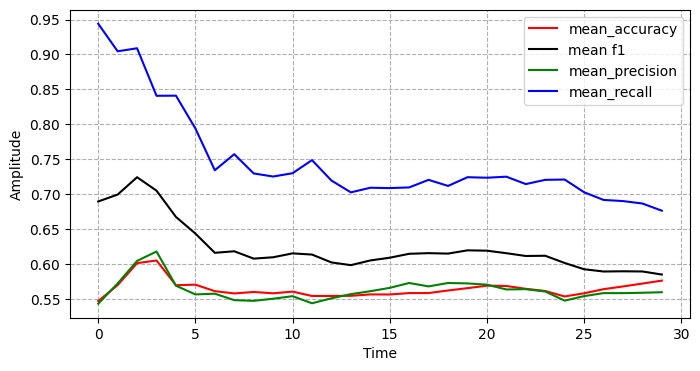

In [7]:
import matplotlib.pyplot as plt

print(f"Mean Accuracy:  {mean_accuracy[-1]:.3f}")
print(f"Mean F1 Score:  {mean_f1[-1]:.3f}")
print(f"Mean Precision: {mean_precision[-1]:.3f}")
print(f"Mean Recall:    {mean_recall[-1]:.3f}")

# Running Test Predictions
plt.figure(figsize=(8, 4))
plt.plot(mean_accuracy, color = "red",label=f"mean_accuracy")
plt.plot(mean_f1, color = "black",label=f"mean f1")
plt.plot(mean_precision, color = "green",label=f"mean_precision")
plt.plot(mean_recall, color = "blue",label=f"mean_recall")
plt.legend()#loc='lower right')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(which='major', linestyle='--', axis='both')

plt.show()